# variational Sequential Monte Carlo
This notebook will serve to troubleshoot the [vSMC](https://arxiv.org/pdf/1705.11140.pdf) algorithm in the _static_ model regime. I will restrict toy examples to prior and posterior models in $\mathbb{R}^1$.

Goals:
1. **Basic demo**: show that SIS and SMC yield better $\log Z$ approximations in the AIS regime as the sequence length increases.
2. **vSMC consistent noise regime**: choose a _short_ sequence length where AIS fails to yield $\log \hat{Z}$ within a few log units of $\log Z$ on average and demonstrate that we can improve the ELBO with vSMC.

melange imports:

In [1]:
from jax import random, grad, value_and_grad, jit, vmap
from jax import numpy as jnp

from melange.smc_objects import StaticULA
from melange.smc import *
from melange.tests.utils import get_nondefault_potential_initializer, get_default_potential_initializer
from melange.tests.utils import checker_function

from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import distplot
%matplotlib inline

define model potentials and forward potentials (i.e. invariant targets of the forward kernels $K_t(x_{t-1}, x_t)$ ).

The prior and posterior distributions ( $\pi_0$, $\pi_T$ resp.) will be parameterized as $\mathcal{N}(x; 0, 0.5)$ and $\mathcal{N}(x; 5, 0.5)$.

The `potential` is defined as $u(x | \lambda) = (1 - \lambda)x^2 + \lambda (x-5)^2$.

The `forward_potential` will be a simple parameterizable neural network potential.

In [2]:
#define a forward (auxiliary) potential
def potential(pos, parameter): #potential will anneal from mean of 0 to 3 (from parameter=0 to 1)
    mod_parameter = parameter[0]
    x0 = jnp.ones(pos.shape)*5 # at lambda=1, the mean is 3.
    return (1. - mod_parameter)*jnp.dot(pos, pos) + mod_parameter*jnp.dot(pos - x0, pos - x0)

define the neural network `forward_potential`

In [14]:
from melange.nn import *
nn_shapes = [1,3,3,3]
template_nn_params = init_network_params(nn_shapes, None)
nn_param_array = arrayize_nn_params(template_nn_params)
nn_potential = simple_nnpotential_generator(potential, sigmoid_nn_potential, 1, template_nn_params)
nn_param_length = len(nn_param_array)

let's run SIS and SMC on N=1000 particles for a range of annealing times in the (approx) AIS regime.

In [12]:
from melange.tests.utils import get_default_potential_initializer
from melange.smc import vSIS_lower_bound, vSMC_lower_bound
from melange.smc_objects import StaticULA
import tqdm

In [5]:
N,Dx = 1000, 1
_, (mu, cov), dG = get_default_potential_initializer(1)
smc_obj= StaticULA(N, potential=potential, forward_potential=potential, backward_potential=potential)
prop, logw, inits = smc_obj.get_fns()

jSIS = jit(vSIS_lower_bound, static_argnums=(5,6,7))
jSMC = jit(vSMC_lower_bound, static_argnums=(5,6,7))

model_params=None

rs = random.PRNGKey(10)

_all_SIS_logZs, _all_SMC_logZs = [], []

T_sequence = jnp.array([5,10,50,100,250,500,1000])

for T in T_sequence:
    rs, run_rs = random.split(rs)
    
    potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis]
    forward_potential_params = potential_params
    backward_potential_params = potential_params[1:]
    forward_dts = 1e-2*jnp.ones(T)
    backward_dts=1e-2*jnp.ones(T)
    y=jnp.zeros(T)
    prop_params = {'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': 1e-2
               }
    init_params = {'mu': mu, 'cov': cov}
    
    SIS_reps = []
    SMC_reps = []
    
    for rep_id in tqdm.trange(100):
        rs, run_rs, run_aux_rs = random.split(rs, 3)
        SIS_logZ =jSIS(prop_params, model_params, y,  run_rs, init_params, prop, logw, inits)
        SMC_logZ = jSMC(prop_params, model_params, y,  run_aux_rs, init_params, prop, logw, inits)
        SIS_reps.append(SIS_logZ)
        SMC_reps.append(SMC_logZ)
    
    SIS_reps = jnp.array(SIS_reps)
    SMC_reps = jnp.array(SMC_reps)
    
    _all_SIS_logZs.append([SIS_reps.mean(), SIS_reps.std()])
    _all_SMC_logZs.append([SMC_reps.mean(), SMC_reps.std()])

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


In [6]:
_all_SIS_logZs = jnp.array(_all_SIS_logZs)
_all_SMC_logZs = jnp.array(_all_SMC_logZs)

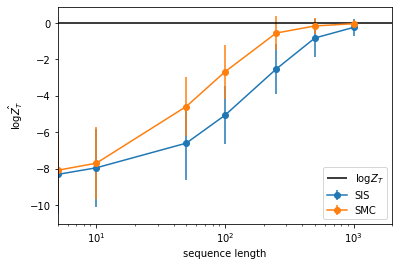

In [7]:
plt.errorbar(T_sequence, _all_SIS_logZs[:,0], yerr = _all_SIS_logZs[:,1], marker='o', label = f"SIS")
plt.errorbar(T_sequence, _all_SMC_logZs[:,0], yerr = _all_SMC_logZs[:,1], marker='o', label = f"SMC")
plt.xscale(f"log")
plt.hlines(0, 5, 2000, label = "$\log Z_T$")
plt.xlabel(f"sequence length")
plt.ylabel("$\log \hat{Z_T}$")
plt.xlim(5, 2000)
plt.legend(loc=4)

it looks like we are underestimating the _True_ $log Z_T$ by several log units at a sequence length of 50 in both SMC and SIS regimes.

Let's start in the _near_ AIS (with SIS) regime with the `simple_neural_network_potential` parameterizing the forward kernels, attempt to take gradient steps in the direction that maximized the $\log \hat{Z_T}$. In principle, if the parameterizable family is sufficiently large, we should be able to converge to the _True_ $\log Z$. 

In [18]:
from melange.nn import init_network_params
smc_obj= StaticULA(500, potential=potential, forward_potential=nn_potential, backward_potential=potential)
prop, logw, inits = smc_obj.get_fns()

T=100
potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis]
#forward_potential_params = [[i, init_network_params([1,3,3], None)] for i in np.linspace(0,1,T)]
#forward_potential_params = jnp.stack((jnp.linspace(0,1,T), jnp.zeros(T), jnp.zeros(T), jnp.zeros(T), jnp.zeros(T), jnp.zeros(T)),1)
#forward_potential_params = jnp.stack((jnp.linspace(0,1,T), jnp.zeros(T), jnp.zeros(T)), 1)
forward_potential_params = jnp.append(jnp.linspace(0,1,100)[..., jnp.newaxis], jnp.zeros((100, nn_param_length)), axis=1)
backward_potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis][1:]
y=jnp.zeros(T)

objective = jit(value_and_grad(vSIS_lower_bound), static_argnums=(5,6,7))
#objective=vSIS_lower_bound
step_size=0.05
prop_params = {'potential_params': potential_params,
           'forward_potential_params': forward_potential_params,
           'backward_potential_params': backward_potential_params,
           'dt': 1e-2}

init_params = {'mu': mu, 'cov': cov}

losses = []
grads = []

rs = random.PRNGKey(10)
for iteration in tqdm.trange(2000):
    rs, run_rs = random.split(rs)
    logZ, gradval = objective(prop_params, model_params, y,  run_rs, init_params, prop, logw, inits)
    #out = objective(prop_params, model_params, y,  run_rs, init_params, prop, logw, inits)
    forward_potential_param_grads = gradval['forward_potential_params']
    prop_params['forward_potential_params'] = prop_params['forward_potential_params'] + step_size*forward_potential_param_grads
    losses.append(logZ)
    grads.append(forward_potential_param_grads)
    
    

100%|██████████| 2000/2000 [01:28<00:00, 22.53it/s]


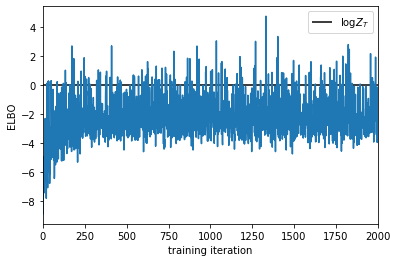

In [19]:
plt.plot(losses)
plt.xlabel(f"training iteration")
plt.ylabel(f"ELBO")
plt.hlines(0, 2000, 0, label = "$\log Z_T$")
plt.xlim(0,2000)
plt.legend()

so, it would look like we can converge in ~100 retrains, and while there is clearly an improvement, the ELBO is certainly noisy.

There's a few potential ways to reduce noise; next, I will attempt to reduce the noise with a few tricks...